In [1]:
# TENSORFLOW 2.0 VISUAL SAERCH USING TF.DATA


from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

#The below commented lines are for ResNet and VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

#from tensorflow.keras.applications import VGG16
#from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
# ResNet and VGG16, img_width, img_height = 224, 224
img_width, img_height = 299, 299


NUM_EPOCHS = 5
batchsize = 10
num_train_images = 1350
num_val_images = 156

#for ResNet, InceptionV3 will be replaced by ResNet50, for VGG, InceptionV3 will be replaced by VGG16

base_model = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

Using TensorFlow backend.


In [2]:
import pathlib
train_dir = 'furniture_images/train'
val_dir = 'furniture_images/validation'
train_dir = pathlib.Path(train_dir)
val_dir = pathlib.Path(val_dir)
output_dir = 'furniture_images/output'

In [3]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))
class_list = ["bed", "chair", "sofa"]

In [4]:
for f in train_ds.take(5):
  print(f.numpy())

b'furniture_images/train/sofa/sofa00000473train.jpg'
b'furniture_images/train/bed/bed00000206train.jpg'
b'furniture_images/train/bed/bed00000214train.jpg'
b'furniture_images/train/sofa/sofa00000462train.jpg'
b'furniture_images/train/bed/bed00000138train.jpg'


In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == class_list


In [6]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])


In [7]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())



Image shape:  (299, 299, 3)
Label:  [False  True False]


In [9]:
val_labeled_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  [False False  True]


In [10]:

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batchsize)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [11]:
train_ds = prepare_for_training(train_labeled_ds)

train_image_batch, label_batch = next(iter(train_ds))

val_ds = prepare_for_training(val_labeled_ds)

val_image_batch, label_batch = next(iter(val_ds))


In [12]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    
    # Fine-tune from this layer onwards
    layer_adjust = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:layer_adjust]:
      layer.trainable =  False

    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model




class_list = ["bed", "chair", "sofa"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

final_model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [13]:
outputpath=output_dir+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_callback = ModelCheckpoint(outputpath, monitor='val_accuracy', verbose=1,save_best_only=False, save_weights_only=False,save_frequency=1)


In [16]:
adam = Adam(lr=0.00001)
final_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = final_model.fit(train_ds,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,callbacks=[checkpoint_callback],validation_data=val_ds, validation_steps=num_val_images // batchsize)


Train for 135 steps, validate for 15 steps
Epoch 1/5
134/135 [============================>.] - ETA: 1s - loss: 0.8139 - accuracy: 0.6754
Epoch 00001: saving model to furniture_images/output/model-01-0.97.hdf5
135/135 [==============================] - 157s 1s/step - loss: 0.8118 - accuracy: 0.6763 - val_loss: 0.3904 - val_accuracy: 0.9667
Epoch 2/5
134/135 [============================>.] - ETA: 1s - loss: 0.3232 - accuracy: 0.9097
Epoch 00002: saving model to furniture_images/output/model-02-0.99.hdf5
135/135 [==============================] - 153s 1s/step - loss: 0.3231 - accuracy: 0.9096 - val_loss: 0.1219 - val_accuracy: 0.9933
Epoch 3/5
134/135 [============================>.] - ETA: 1s - loss: 0.1946 - accuracy: 0.9403
Epoch 00003: saving model to furniture_images/output/model-03-0.99.hdf5
135/135 [==============================] - 155s 1s/step - loss: 0.1947 - accuracy: 0.9400 - val_loss: 0.0683 - val_accuracy: 0.9933
Epoch 4/5
134/135 [============================>.] - ETA: 1s

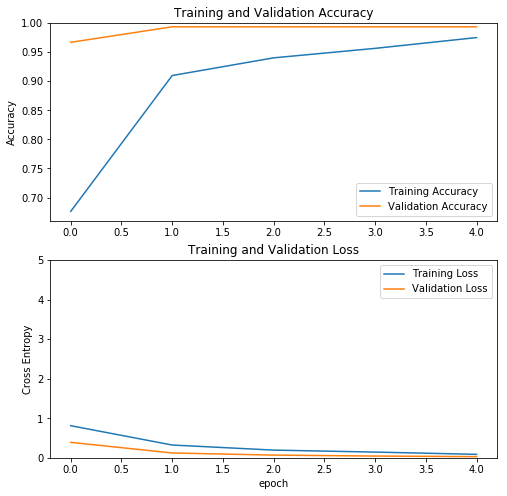

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
from keras.preprocessing import image
import numpy as np
# the below path shows the full path for uploaded image, adjust it for your specific path
#img_path = '/home/.../visual_search/furniture-detector/img/train/bed/00000002.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/chair/00000009.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/sofa/00000016.jpg'
img_path = 'furniture_images/val/sofa/sofaval03.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

pretrained_feature = final_model.predict(img_data,verbose=0)
pretrained_feature_np = np.array(pretrained_feature)
pretrained_feature1D = pretrained_feature_np.flatten()

print (pretrained_feature1D)
y_prob = final_model.predict(img_data)

y_classes = y_prob.argmax(axis=-1)
print (y_classes)

[0.02501939 0.00169387 0.9732867 ]
[2]


In [20]:
import os
from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity

# Below shows the full path for test images, adjust it for your specific path
if y_classes == [0]:
    path = 'furniture_images/test/bed'
elif y_classes == [1]:
    path = 'furniture_images/test/chair'
else:
    path = 'furniture_images/test/sofa'
    
mindist=10000
maxcosine =0
i=0
for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(img_width, img_height))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)

    pretrained_feature_train = final_model.predict(img_data_train)
    pretrained_feature_np_train = np.array(pretrained_feature_train)
    pretrained_feature_train1D = pretrained_feature_np_train.flatten()
    eucldist = dist.euclidean(pretrained_feature1D,pretrained_feature_train1D)
    
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
    #print (vgg16_feature_np)
    
    dot_product = np.dot(pretrained_feature1D,pretrained_feature_train1D)#normalize the results, to achieve similarity measures independant #of the scale of the vectors
    norm_Y = np.linalg.norm(pretrained_feature1D)
    norm_X = np.linalg.norm(pretrained_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    
    
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))


00000813testsofa.jpg filename 0.012073 euclediandist 0.999972 cosine_similarity
00000813testsofa.jpg minfilename 0.012073 mineuclediandist 00000813testsofa.jpg cosfilename 0.999972 maxcosinesimilarity
00000821testsofa.jpg filename 0.011852 euclediandist 0.999941 cosine_similarity
00000821testsofa.jpg minfilename 0.011852 mineuclediandist 00000813testsofa.jpg cosfilename 0.999972 maxcosinesimilarity
00000805testsofa.jpg filename 0.034105 euclediandist 0.999686 cosine_similarity
00000821testsofa.jpg minfilename 0.011852 mineuclediandist 00000813testsofa.jpg cosfilename 0.999972 maxcosinesimilarity
00000807testsofa.jpg filename 0.035647 euclediandist 0.999684 cosine_similarity
00000821testsofa.jpg minfilename 0.011852 mineuclediandist 00000813testsofa.jpg cosfilename 0.999972 maxcosinesimilarity
00000829testsofa.jpg filename 0.044600 euclediandist 0.999550 cosine_similarity
00000821testsofa.jpg minfilename 0.011852 mineuclediandist 00000813testsofa.jpg cosfilename 0.999972 maxcosinesimila

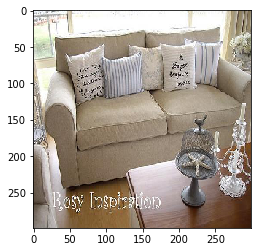

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 0.9999723')

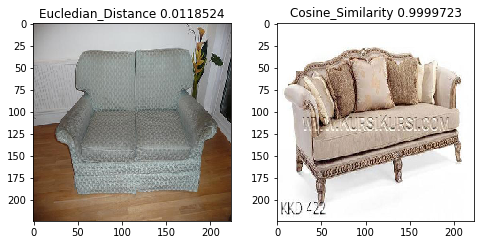

In [22]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Eucledian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))

In [23]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batchsize*steps/duration))


In [24]:
from keras.preprocessing.image import ImageDataGenerator



train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 1350 images belonging to 3 classes.


In [25]:
timeit(train_generator)

....................................................................................................
1000 batches: 142.58274674415588 s
70.13471 Images/s


In [26]:
timeit(train_ds)

....................................................................................................
1000 batches: 1.5855846405029297 s
6306.82194 Images/s
